In [2]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("techsash/waste-classification-data")

print("Path to dataset files:", path)

100%|██████████| 427M/427M [00:11<00:00, 38.2MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/techsash/waste-classification-data/versions/1


In [3]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
import tensorflow as tf
from tqdm import tqdm
from glob import glob
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Activation, Dropout, Flatten, Dense, BatchNormalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

# Suppress warnings for clarity
import warnings
warnings.filterwarnings('ignore')

In [4]:
train_path = "/root/.cache/kagglehub/datasets/techsash/waste-classification-data/versions/1/DATASET/TRAIN"
test_path = "/root/.cache/kagglehub/datasets/techsash/waste-classification-data/versions/1/DATASET/TEST"

In [5]:
# Visualization
from cv2 import cvtColor
x_data = []
y_data = []
for category in glob(train_path+'/*'):
    for file in tqdm(glob(category+'/*')):
        img_array = cv2.imread(file)
        img_array = cv2.cvtColor(img_array, cv2.COLOR_BGR2RGB)
        x_data.append(img_array)
        y_data.append(category.split("/")[-1])
data = pd.DataFrame({'image': x_data, 'label': y_data})


100%|██████████| 12565/12565 [00:06<00:00, 2011.74it/s]


In [6]:
data.shape

(22564, 2)

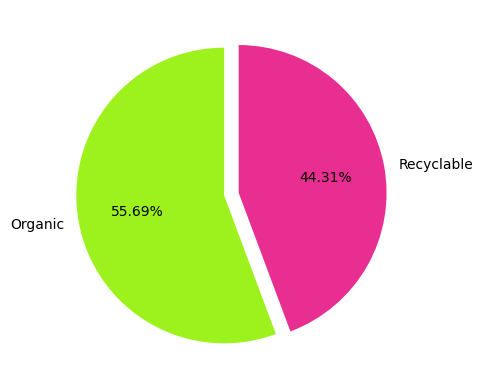

In [7]:
colors = ['#9df21d', '#e82e91']
plt.pie(data.label.value_counts(), labels=['Organic', 'Recyclable'], autopct='%0.2f%%',
        colors=colors, startangle=90, explode=[0.05, 0.05])
plt.show()

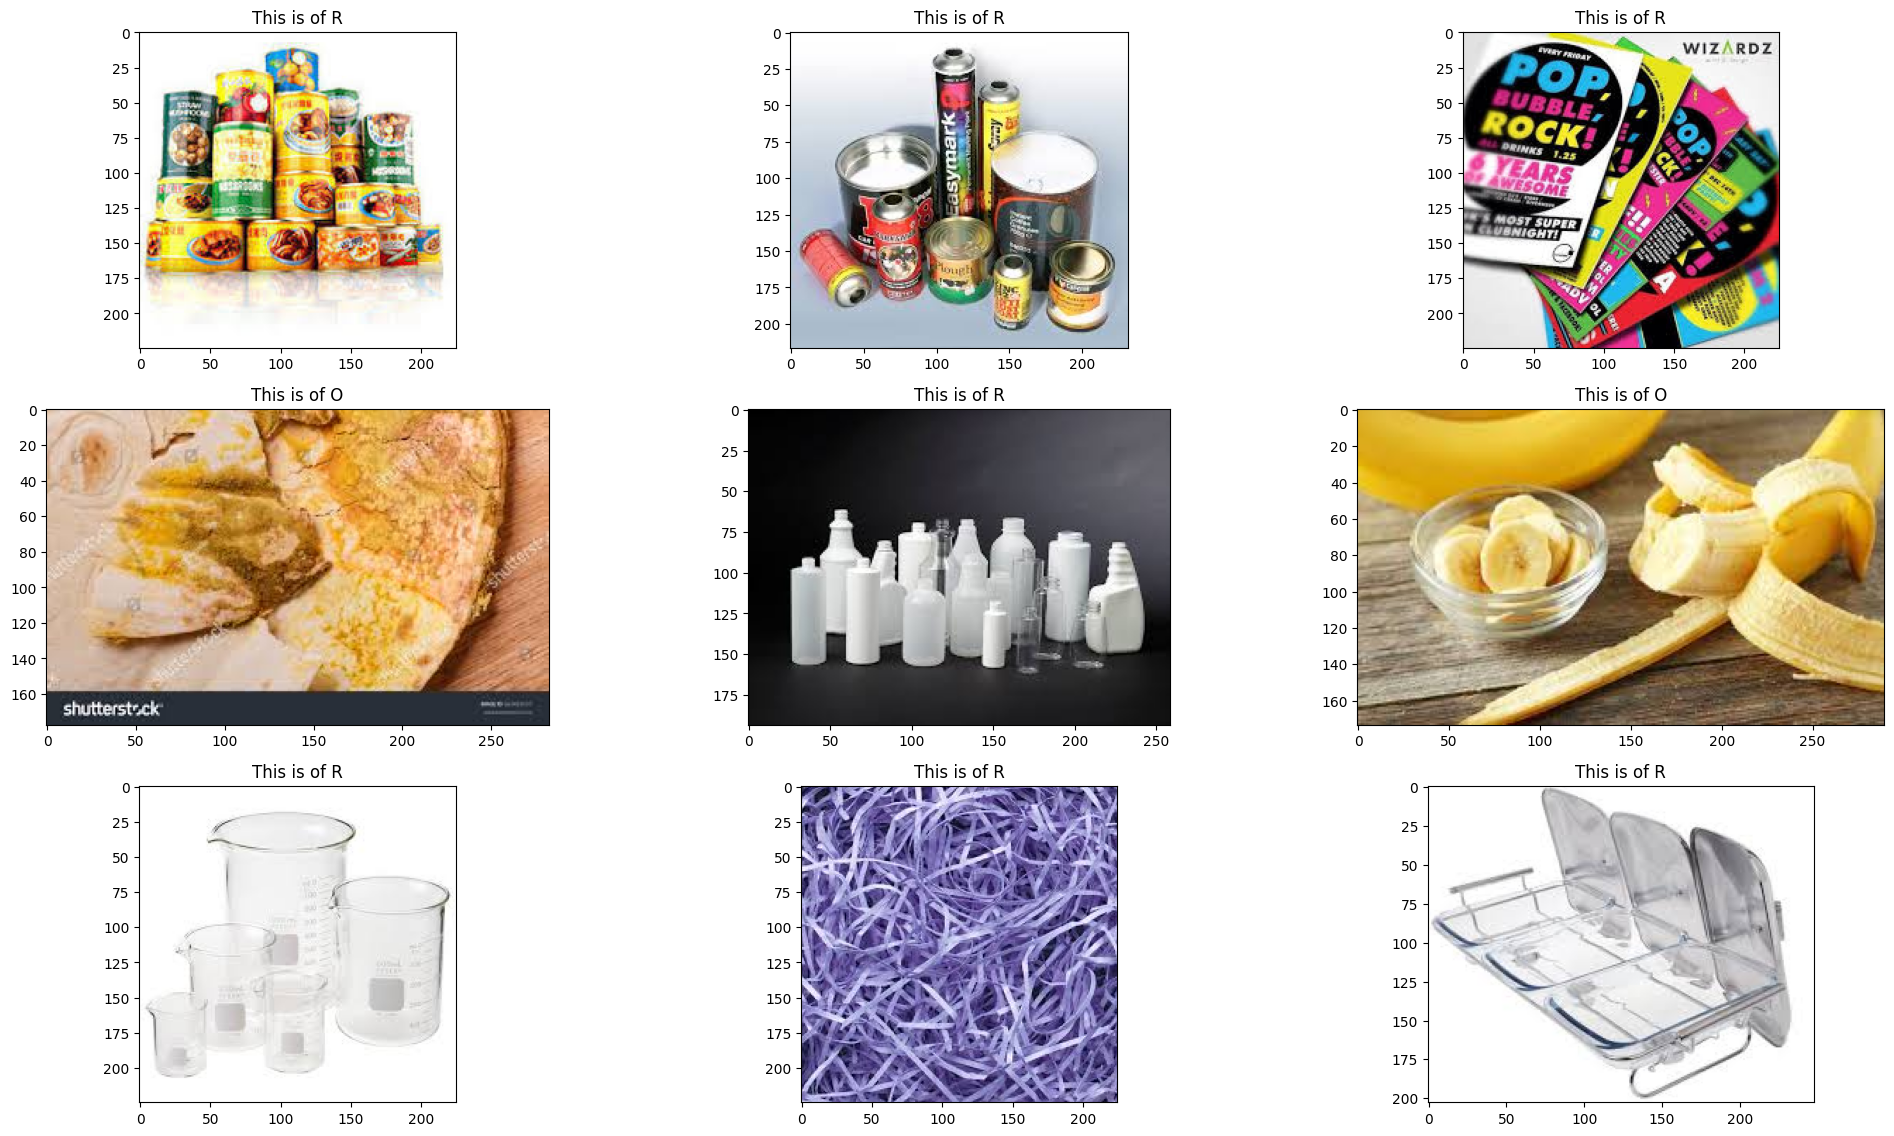

In [8]:
plt.figure(figsize=(20, 15))
for i in range(9):
    plt.subplot(4, 3,(i%12)+1)
    index = np.random.randint(15000)
    plt.title('This is of {0}'.format(data.label[index]))
    plt.imshow(data.image[index])
    plt.tight_layout()

In [9]:
# Data Augmentation for better generalization
"""
We use `ImageDataGenerator` to apply transformations such as:
- Rotation, width/height shift, shear, zoom, and flipping
- Rescaling pixel values to [0,1]
- Splitting training data into training (80%) and validation (20%)
"""
datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest',
    validation_split=0.2
)

In [10]:
# Load training and validation data
"""
Generate training and validation datasets using augmentation.
Target size: 150x150 pixels, batch size: 32, class mode: categorical.
"""
train_generator = datagen.flow_from_directory(
    train_path,
    target_size=(150, 150),
    batch_size=32,
    class_mode='categorical',
    subset='training'
)
validation_generator = datagen.flow_from_directory(
    train_path,
    target_size=(150, 150),
    batch_size=32,
    class_mode='categorical',
    subset='validation'
)

Found 18052 images belonging to 2 classes.
Found 4512 images belonging to 2 classes.


In [11]:
#building a CNN model

def build_model():
    model = Sequential([
        Conv2D(32, (3,3), activation='relu', input_shape=(150,150,3)),
        MaxPooling2D(2,2),
        BatchNormalization(),

        Conv2D(64, (3,3), activation='relu'),
        MaxPooling2D(2,2),
        BatchNormalization(),

        Conv2D(128, (3,3), activation='relu'),
        MaxPooling2D(2,2),
        BatchNormalization(),

        Flatten(),
        Dense(512, activation='relu'),
        Dropout(0.5),
        Dense(len(train_generator.class_indices), activation='softmax')
    ])
    return model

In [12]:
# Compile the CNN model

model = build_model()
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [13]:
# Display Model Summary

model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 148, 148, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 74, 74, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 74, 74, 32)          │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 72, 72, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 36, 36, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 36, 36, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 34, 34, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 17, 17, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 17, 17, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 36992)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 512)                 │      18,940,416 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 2)                   │           1,026 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 19,035,586 (72.61 MB)

 Trainable params: 19,035,138 (72.61 MB)

 Non-trainable params: 448 (1.75 KB)

In [14]:
# Implement early stopping and checkpointing

callbacks = [
    EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True),
    ModelCheckpoint('best_model.keras', save_best_only=True)  # Updated file format
]

In [15]:
# Train the CNN model

history = model.fit(
    train_generator,
    validation_data=validation_generator,
    epochs=15,
    callbacks=callbacks
)

Epoch 1/15
565/565 ━━━━━━━━━━━━━━━━━━━━ 151s 251ms/step - accuracy: 0.7378 - loss: 1.3058 - val_accuracy: 0.7757 - val_loss: 0.6705
Epoch 2/15
565/565 ━━━━━━━━━━━━━━━━━━━━ 147s 260ms/step - accuracy: 0.7905 - loss: 0.7081 - val_accuracy: 0.8098 - val_loss: 0.5140
Epoch 3/15
565/565 ━━━━━━━━━━━━━━━━━━━━ 154s 272ms/step - accuracy: 0.8030 - loss: 0.5886 - val_accuracy: 0.7883 - val_loss: 0.6392
Epoch 4/15
565/565 ━━━━━━━━━━━━━━━━━━━━ 133s 235ms/step - accuracy: 0.8144 - loss: 0.5304 - val_accuracy: 0.7748 - val_loss: 0.5275
Epoch 5/15
565/565 ━━━━━━━━━━━━━━━━━━━━ 134s 237ms/step - accuracy: 0.8280 - loss: 0.4829 - val_accuracy: 0.8276 - val_loss: 0.4253
Epoch 6/15
565/565 ━━━━━━━━━━━━━━━━━━━━ 133s 236ms/step - accuracy: 0.8391 - loss: 0.4221 - val_accuracy: 0.8251 - val_loss: 0.4598
Epoch 7/15
565/565 ━━━━━━━━━━━━━━━━━━━━ 143s 238ms/step - accuracy: 0.8457 - loss: 0.4005 - val_accuracy: 0.8464 - val_loss: 0.3630
Epoch 8/15
565/565 ━━━━━━━━━━━━━━━━━━━━ 141s 236ms/step - accuracy: 0.8428 -

In [16]:
model.save("Waste-Classification-CNN-Model.h5")

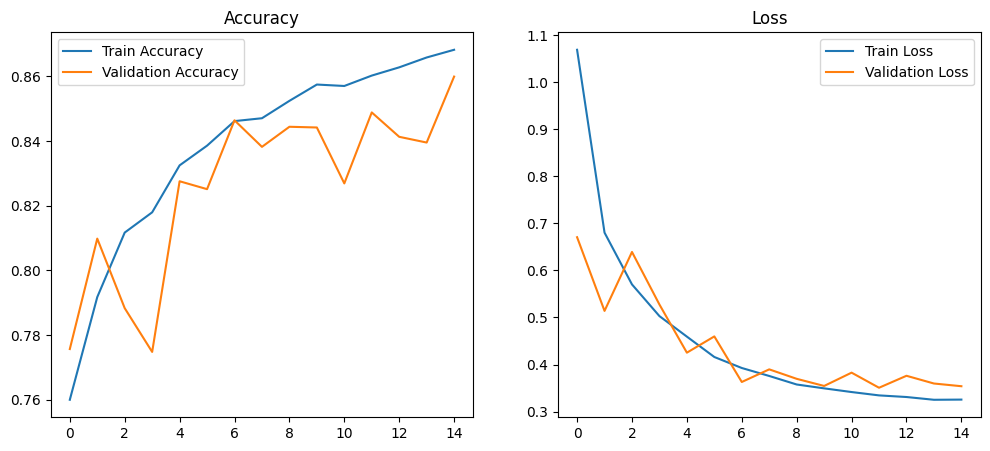

In [17]:
# Plot training history
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.legend()
plt.title('Accuracy')

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.title('Loss')

plt.show()

In [18]:
# Load the Trained Model

from tensorflow.keras.models import load_model

# Load the best saved model
model = load_model("Waste-Classification-CNN-Model.h5")

# Display the model architecture again to verify loading
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 148, 148, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 74, 74, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 74, 74, 32)          │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 72, 72, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 36, 36, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 36, 36, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 34, 34, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 17, 17, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 17, 17, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 36992)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 512)                 │      18,940,416 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 2)                   │           1,026 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 19,035,588 (72.62 MB)

 Trainable params: 19,035,138 (72.61 MB)

 Non-trainable params: 448 (1.75 KB)

 Optimizer params: 2 (12.00 B)

In [19]:
# Prepare Test Data

test_path = "/root/.cache/kagglehub/datasets/techsash/waste-classification-data/versions/1/DATASET/TEST"

# Rescale test images to match training data
test_datagen = ImageDataGenerator(rescale=1./255)

# Load test dataset with similar preprocessing
test_generator = test_datagen.flow_from_directory(
    test_path,
    target_size=(150, 150),
    batch_size=32,
    class_mode='categorical',
    shuffle=False  # Do not shuffle so that labels remain aligned
)

Found 2513 images belonging to 2 classes.


In [21]:
# Evaluate model accuracy on test set
test_loss, test_accuracy = model.evaluate(test_generator)

print(f"Test Accuracy: {test_accuracy * 100:.2f}%")
print(f"Test Loss: {test_loss:.4f}")

79/79 ━━━━━━━━━━━━━━━━━━━━ 3s 39ms/step - accuracy: 0.8767 - loss: 0.4009
Test Accuracy: 84.48%
Test Loss: 0.4245


In [22]:
# Make Predictions on Test Images

import numpy as np

# Get predictions (probabilities)
predictions = model.predict(test_generator)

# Convert probabilities to class labels
predicted_classes = np.argmax(predictions, axis=1)

# Get actual class labels from test generator
actual_classes = test_generator.classes

# Get class labels (to map indices back to names)
class_labels = list(test_generator.class_indices.keys())

# Print sample predictions
print("Predicted Classes:", [class_labels[i] for i in predicted_classes[:10]])
print("Actual Classes:", [class_labels[i] for i in actual_classes[:10]])

79/79 ━━━━━━━━━━━━━━━━━━━━ 3s 35ms/step
Predicted Classes: ['O', 'O', 'O', 'O', 'R', 'O', 'O', 'O', 'O', 'O']
Actual Classes: ['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']


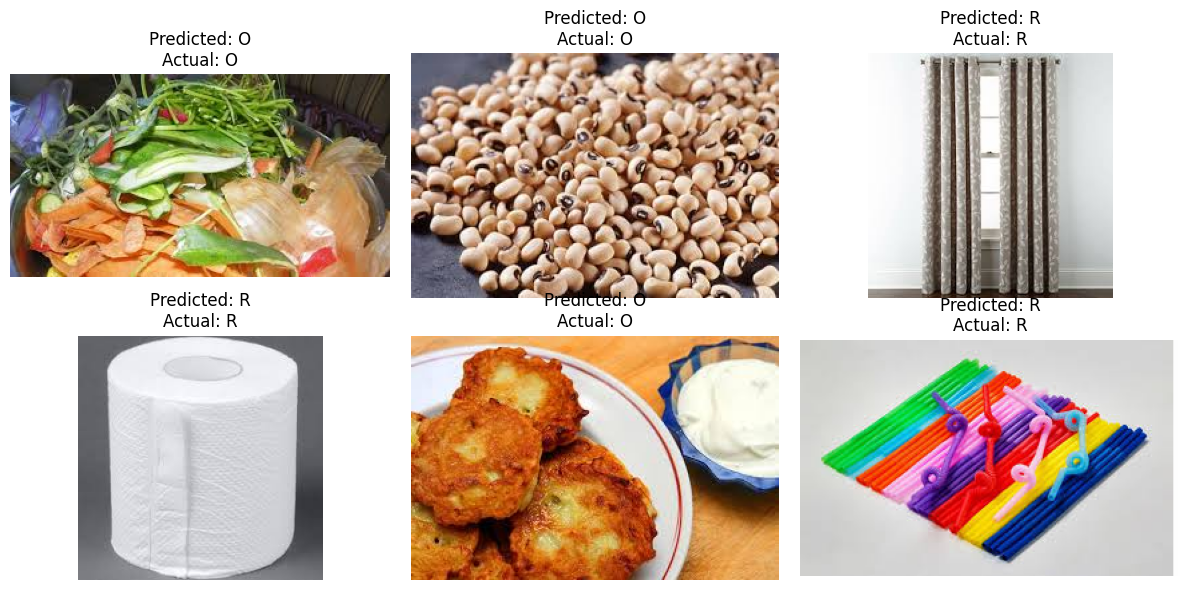

In [23]:
"""
# Visualize Some Test Images with Predictions
We randomly select some test images and display them with predicted labels.
"""
import matplotlib.pyplot as plt

# Get file names for test images
test_image_paths = test_generator.filepaths

# Select random indices
random_indices = np.random.choice(len(test_image_paths), 6, replace=False)

plt.figure(figsize=(12, 6))

for i, idx in enumerate(random_indices):
    img = cv2.imread(test_image_paths[idx])
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convert BGR to RGB for correct color display

    # Get predicted label
    predicted_label = class_labels[predicted_classes[idx]]
    actual_label = class_labels[actual_classes[idx]]

    plt.subplot(2, 3, i + 1)
    plt.imshow(img)
    plt.axis('off')
    plt.title(f"Predicted: {predicted_label}\nActual: {actual_label}", fontsize=12)

plt.tight_layout()
plt.show()



       🔹 CLASSIFICATION REPORT 🔹        

              precision    recall  f1-score   support

           O       0.85      0.87      0.86      1401
           R       0.83      0.81      0.82      1112

    accuracy                           0.84      2513
   macro avg       0.84      0.84      0.84      2513
weighted avg       0.84      0.84      0.84      2513



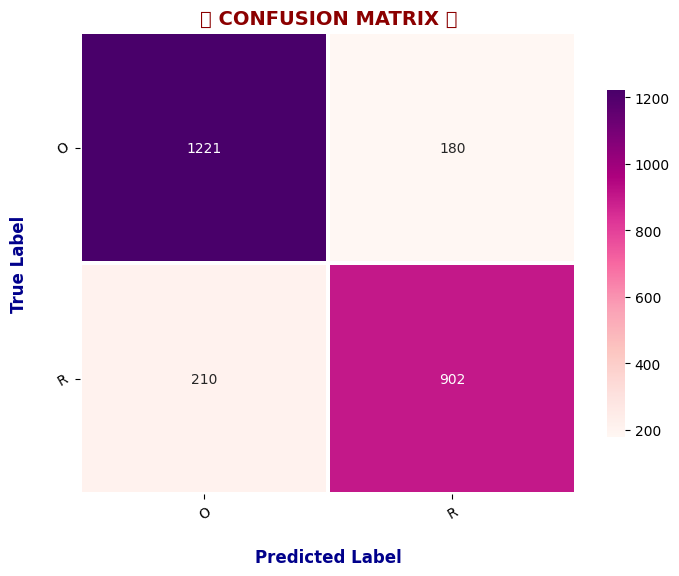

In [31]:

# from sklearn.metrics import classification_report, confusion_matrix

# # Print classification report
# print("Classification Report:\n")
# print(classification_report(actual_classes, predicted_classes, target_names=class_labels))

# # Generate and plot confusion matrix
# import seaborn as sns

# cm = confusion_matrix(actual_classes, predicted_classes)

# plt.figure(figsize=(8, 6))
# sns.heatmap(cm, annot=True, fmt="d", cmap="YlOrBr", xticklabels=class_labels, yticklabels=class_labels)
# plt.xlabel("Predicted Label")
# plt.ylabel("True Label")
# plt.title("Confusion Matrix")
# plt.show()

from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Print classification report with formatting
print("\n" + "="*40)
print("🔹 CLASSIFICATION REPORT 🔹".center(40))
print("="*40 + "\n")
print(classification_report(actual_classes, predicted_classes, target_names=class_labels))

# Generate and plot confusion matrix with a different visual style
cm = confusion_matrix(actual_classes, predicted_classes)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="RdPu", linewidths=1.5,
            xticklabels=class_labels, yticklabels=class_labels, cbar_kws={"shrink": 0.75})

# Stylized Labels and Titles
plt.xlabel("\nPredicted Label", fontsize=12, fontweight='bold', color='darkblue')
plt.ylabel("True Label\n", fontsize=12, fontweight='bold', color='darkblue')
plt.title("📌 CONFUSION MATRIX 📌", fontsize=14, fontweight='bold', color='darkred')

plt.xticks(rotation=30)
plt.yticks(rotation=30)

plt.show()

